In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import itertools as iter

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)


2023-08-22 17:24:05.412405: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 17:24:05.877352: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
/mnt/e/ML/MonetGAN


2023-08-22 17:24:06.708795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 17:24:06.728060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 17:24:06.728406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


## Dataset

In [2]:
allFiles=[]
for root, dirs, files in os.walk(os.path.join(DATA_PATH, "processed")):
    for f in files:
        allFiles.append(os.path.join(root, f))

In [3]:
T=100
beta = np.linspace(1e-4, 0.02,100)
alpha = 1-beta
alphaBar = [np.prod(alpha[0:i+1]) for i,el in enumerate(alpha)]
IMAGE_SIZE = [256,256]

def generator():
    for i,file in enumerate(allFiles):
        image = tf.io.read_file(file)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.95, 1.05)
        image = (tf.cast(image, tf.float32) / 127.5) - 1
        x0 = image.numpy()
        for t in range(T):
            # noise = np.random.normal(np.sqrt(alpha[t]), 1-alpha[t], (x0.shape[0], x0.shape[1], x0.shape[2]))
            noise = np.random.normal(0, 1-alphaBar[t], (x0.shape[0], x0.shape[1], x0.shape[2]))
            noisy = np.sqrt(alphaBar[t])*x0 + np.sqrt(1-alphaBar[t])*noise
            yield noisy, noise

In [4]:
g = generator()
test = next(g)
print(test[0].shape)
print(test[1].shape)

2023-08-22 17:24:06.784705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 17:24:06.785129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 17:24:06.785456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 17:24:07.244210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 17:24:07.244610: I tensorflow/compile

(256, 256, 3)
(256, 256, 3)


In [5]:
test = next(g)
np.max(test[1])

0.0017623442655347588

(-0.5, 255.5, 255.5, -0.5)

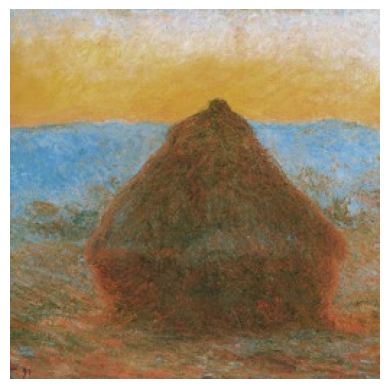

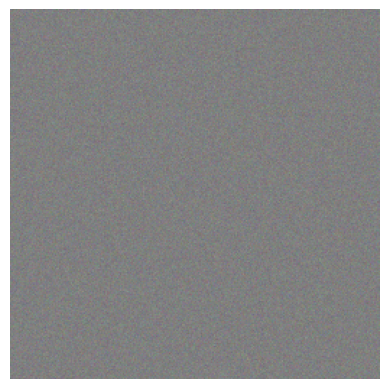

In [27]:
test = next(g)
plt.imshow((test[0]+1)/2)
plt.axis('off')
plt.figure()
plt.imshow((test[1]+1)/2)
plt.axis('off')

In [7]:
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
                            tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32)))


## Tensorflow

In [8]:
%load_ext tensorboard


Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 3)          12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 3)          0         ['batch_normalization[0][0]'] 
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         448       ['leaky_re_lu[0][0]']      

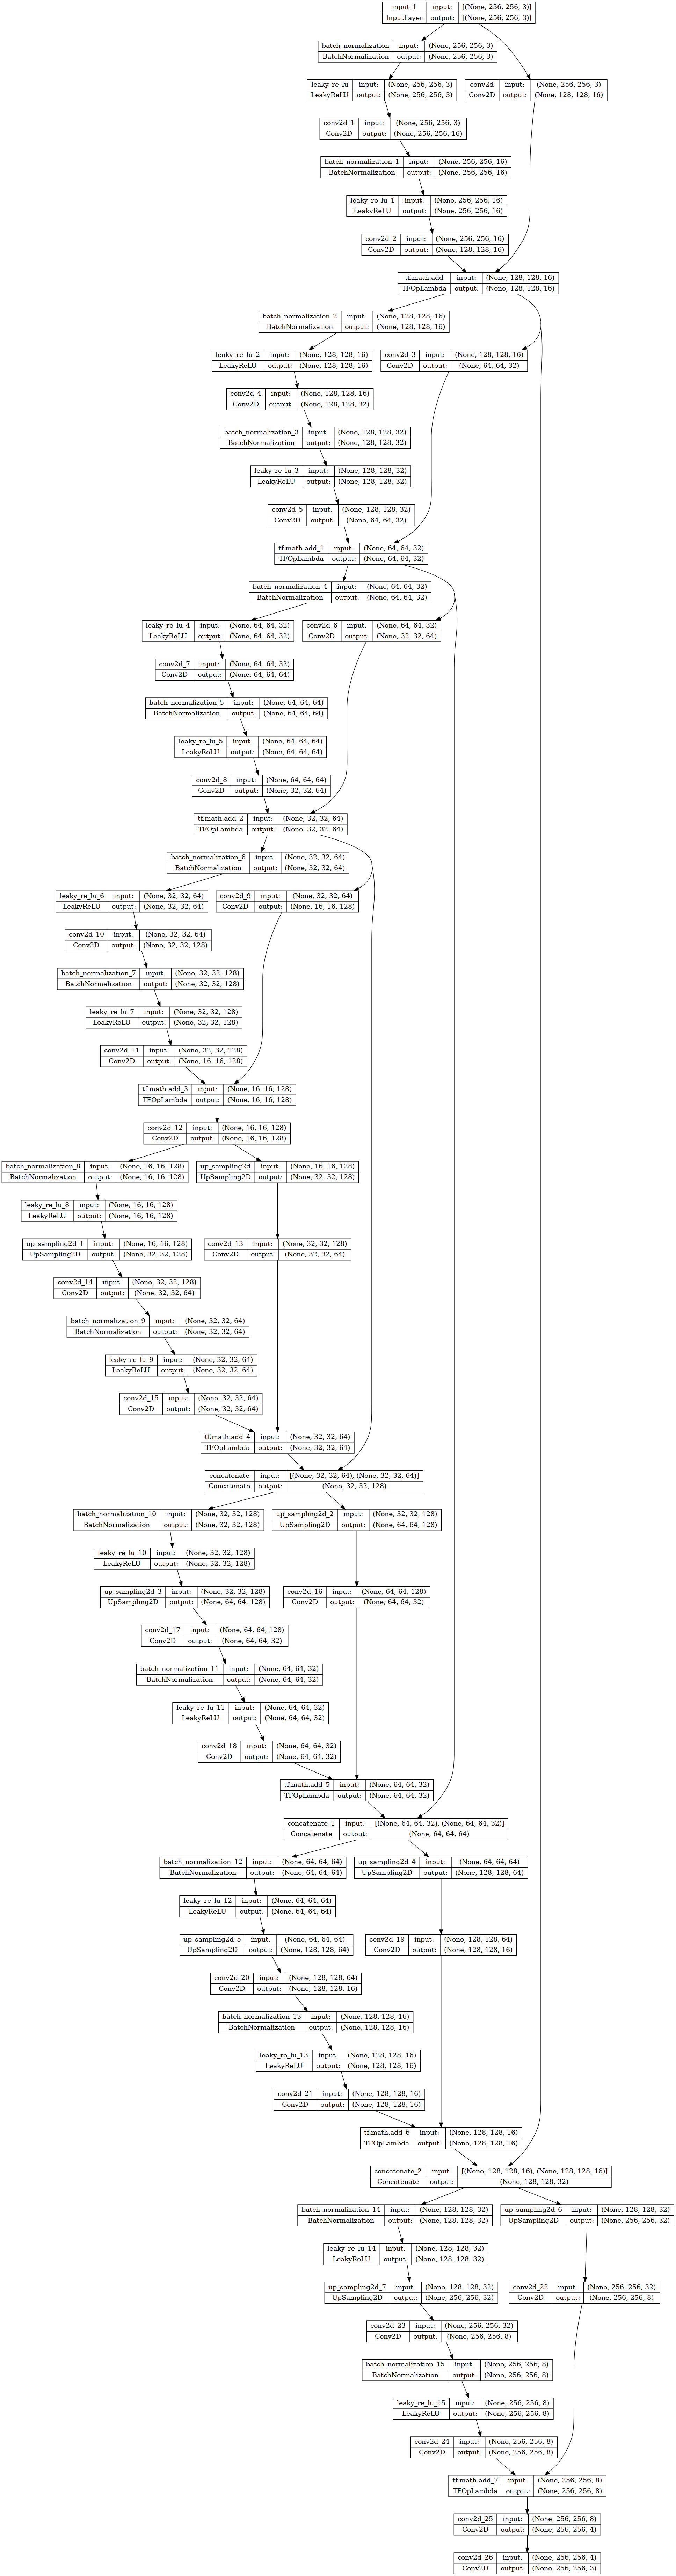

In [9]:
from tensorflow.keras import layers

def downscaleBlock(xIn, ch, filtersize):
    xRes = tf.keras.layers.Conv2D(ch, 1, strides=2,  padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(xIn)
    # xRes = tf.keras.layers.AveragePooling2D((3,3), strides=2)(xRes)

    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", strides=2, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(x)
    
    return tf.math.add(x, xRes)


def upscaleBlock(xIn, ch, filtersize):
    xRes = tf.keras.layers.UpSampling2D(size=(2, 2))(xIn)
    xRes = tf.keras.layers.Conv2D(ch, 1, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(xRes)

    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(x)

    return tf.math.add(x, xRes)



def createUnet():
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
    #256

    xDown4 = downscaleBlock(inputs, 16, 3)
    #128

    xDown8 = downscaleBlock(xDown4, 32, 3)
    #64

    xDown16 = downscaleBlock(xDown8 ,64, 3)
    #32

    xDown32 = downscaleBlock(xDown16 ,128, 3)
    #16x16

    xCenter = tf.keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(xDown32)
    #16x16

    xUp16 = upscaleBlock(xCenter, 64, 3)
    #32x32
    xConcat16 = tf.keras.layers.Concatenate()([xUp16, xDown16])

    xUp8 = upscaleBlock(xConcat16, 32, 3)
    #64
    xConcat8 = tf.keras.layers.Concatenate()([xDown8, xUp8])

    xUp4 = upscaleBlock(xConcat8, 16, 3)
    #128
    xConcat4 = tf.keras.layers.Concatenate()([xDown4, xUp4])

    xUp4 = upscaleBlock(xConcat4, 8, 3)
    #256
    
    x=tf.keras.layers.Conv2D(4, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(xUp4)

    outputs=tf.keras.layers.Conv2D(3, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="unet")


model = createUnet()

model.summary()

dot_img_file = './'+model.name +'.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


In [10]:
loadExistingModel=False

if loadExistingModel:
    generator = tf.keras.models.load_model(os.path.join(DATA_PATH, "generator_epoch_190"))
    discriminator = tf.keras.models.load_model(os.path.join(DATA_PATH, "discriminator_epoch_190"))

In [11]:
def saveImages(model, epoch):
  testInput = tf.random.uniform((9, 1024))
  predictions = model(testInput, training=False)

  fig = plt.figure(figsize=(5, 5))

  for i in range(predictions.shape[0]):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.rint(predictions[i, :, :, :] * 127.5 + 127.5).astype(int))
    plt.axis('off')

  plt.savefig(os.path.join(DATA_PATH,"trainImages", 'epoch_{:04d}.png'.format(epoch)))
  plt.close()

In [12]:

BATCH_SIZE=64
LOG_INTERVAL=20
epochs = 1
saveModel=False

startEpoch=0


log_dir = "./logs/"+model.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-4)

# Instantiate a loss function.
lossFn = tf.keras.losses.MeanSquaredError()
# lossFn = tf.keras.losses.BinaryCrossentropy()


# batchedDataset = datasetMonet.batch(BATCH_SIZE, drop_remainder=False)
datasetShuffled = dataset.shuffle(200)
batchedDataset = datasetShuffled.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)



@tf.function()
def trainStep(image, noise):
    with tf.GradientTape() as tape:
        predictedNoise = model(image, training=True) 

        loss = lossFn(predictedNoise, noise)


    grads = tape.gradient(loss, model.trainable_weights)


    optimizer.apply_gradients(zip(grads, model.trainable_weights)) 

    return loss



maxStep=len(allFiles)*T//BATCH_SIZE


for epoch in np.arange(startEpoch, startEpoch+epochs, 1):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (image,noise) in enumerate(batchedDataset):
        loss = trainStep(image,noise)


        # Log 
        if step % LOG_INTERVAL == 0:
            template = 'Epoch {}/Step {}, Loss: {:.4f}'
            print(template.format(epoch, step, loss.numpy()))
            
            with summary_writer.as_default():
                tf.summary.scalar('loss', loss, step=maxStep*epoch+step)
                summary_writer.flush()

    maxStep=step


    # print("Saving images")
    # saveImages(generator, epoch)

    if saveModel and epoch%10==0:
      generator.save(os.path.join(DATA_PATH, "generator_"+"epoch_{}".format(epoch)))
      discriminator.save(os.path.join(DATA_PATH, "discriminator_"+"epoch_{}".format(epoch)))

print("done")


Start of epoch 0


2023-08-22 16:50:51.419247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-22 16:50:54.623049: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-22 16:50:55.087068: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-22 16:50:55.087134: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

Epoch 0/Step 0, Loss: 3.0922
Epoch 0/Step 20, Loss: 0.6502
Epoch 0/Step 40, Loss: 0.3040
Epoch 0/Step 60, Loss: 0.2206
Epoch 0/Step 80, Loss: 0.2032
Epoch 0/Step 100, Loss: 0.1958
Epoch 0/Step 120, Loss: 0.1776
Epoch 0/Step 140, Loss: 0.1303
Epoch 0/Step 160, Loss: 0.1598
Epoch 0/Step 180, Loss: 0.1440
Epoch 0/Step 200, Loss: 0.1475
Epoch 0/Step 220, Loss: 0.1154
Epoch 0/Step 240, Loss: 0.1458
Epoch 0/Step 260, Loss: 0.1361
Epoch 0/Step 280, Loss: 0.1021
Epoch 0/Step 300, Loss: 0.1057
Epoch 0/Step 320, Loss: 0.1299
Epoch 0/Step 340, Loss: 0.1098
Epoch 0/Step 360, Loss: 0.0898
Epoch 0/Step 380, Loss: 0.0904
Epoch 0/Step 400, Loss: 0.0996
Epoch 0/Step 420, Loss: 0.1223
Epoch 0/Step 440, Loss: 0.1000
Epoch 0/Step 460, Loss: 0.0940
Epoch 0/Step 480, Loss: 0.0969
Epoch 0/Step 500, Loss: 0.1045
Epoch 0/Step 520, Loss: 0.1006
Epoch 0/Step 540, Loss: 0.1033
Epoch 0/Step 560, Loss: 0.0839
Epoch 0/Step 580, Loss: 0.0800
Epoch 0/Step 600, Loss: 0.0993
Epoch 0/Step 620, Loss: 0.0971
Epoch 0/Step 6

KeyboardInterrupt: 

In [13]:
initInput = tf.random.normal((1, *IMAGE_SIZE, 3), dtype=tf.float32)
new = initInput
for t in np.arange(0,T)[::-1]:
    predNoise = model(new)
    new = (new - (beta[t])/np.sqrt(1-alphaBar[t])*predNoise)/np.sqrt(alpha[t])
    if t>1:
        new = new + np.sqrt(beta[t])*np.random.normal(0,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


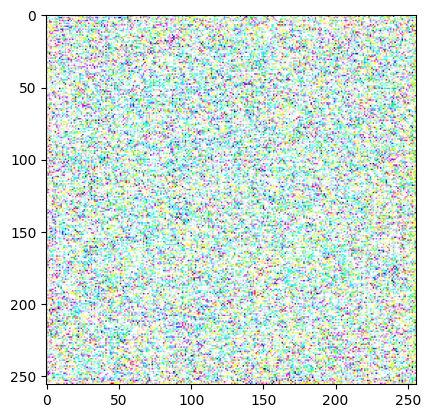

In [14]:
plt.imshow((new.numpy()[0,:,:,:]+1)/2)

In [20]:
testImage=tf.expand_dims(list(dataset.take(50))[49][0],0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


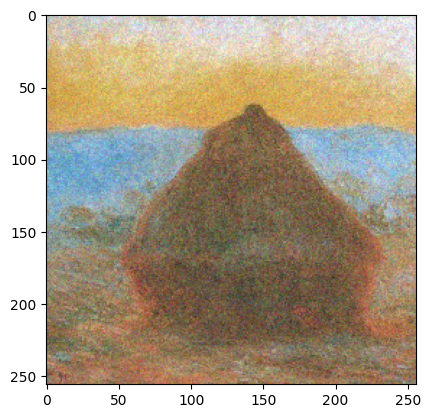

In [21]:
plt.imshow((testImage.numpy()[0,:,:,:]+1)/2)

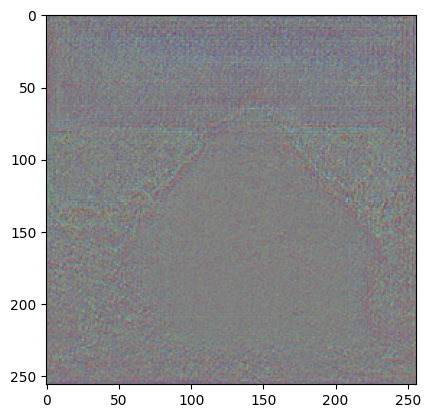

In [22]:
predNoise = model(testImage)
plt.imshow((predNoise.numpy()[0,:,:,:]+1)/2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


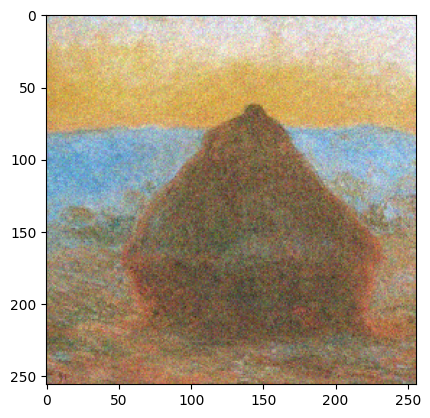

In [23]:
denoised = (testImage - (1-alpha[49])/np.sqrt(1-alphaBar[49])*predNoise)/np.sqrt(alpha[49])
plt.imshow((denoised.numpy()[0,:,:,:]+1)/2)